In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/random-images-for-face-emotion-recognition/surprise/images (68)_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202610.051_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T203343.130_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202951.236_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202431.675_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202508.777_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T004452.516_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T202620.534_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise/images - 2020-11-06T203753.431_face.png
/kaggle/input/random-images-for-face-emotion-recognition/surprise

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models

# List what's available under /kaggle/input
for d in os.listdir("/kaggle/input"):
    print(d)


DATASET_DIR = "/kaggle/input/random-images-for-face-emotion-recognition"


print("Subfolders:", os.listdir(DATASET_DIR))

2025-09-02 14:41:52.335026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756824112.671265      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756824112.764922      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


random-images-for-face-emotion-recognition
Subfolders: ['surprise', 'fear', 'sadness', 'neutrality', 'disgust', 'contempt', 'happiness', 'anger']


In [3]:


base_dir = DATASET_DIR
img_size = (224, 224)
batch_size = 32

train_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    label_mode="categorical"  # one-hot
)

temp_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.30,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Split temp into val/test (15/15)
val_batches = tf.data.experimental.cardinality(temp_raw)
test_size   = val_batches // 2
test_raw    = temp_raw.take(test_size)
val_raw     = temp_raw.skip(test_size)

Found 5558 files belonging to 8 classes.
Using 3891 files for training.


I0000 00:00:1756824130.427159      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756824130.427861      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5558 files belonging to 8 classes.
Using 1667 files for validation.
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']


In [4]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

size = (IMG_SIZE, IMG_SIZE)
ds_train = train_raw.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = val_raw.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = test_raw.map(lambda image, label: (tf.image.resize(image, size), label))

In [5]:
#transfer learning with a frozen backbone

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


# Load base model (no top classification head)
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"  # adds a global average pooling
)

base_model.trainable = False  # freeze base for now


model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),  # built-in EfficientNet scaler
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,571 (16.08 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("mobilenetv2_baseline.keras", monitor="val_accuracy", save_best_only=True),
]

history = model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=callbacks)
print("Frozen backbone eval:", model.evaluate(ds_test, verbose=0))

Epoch 1/50


I0000 00:00:1756824203.222355     107 service.cc:148] XLA service 0x7bb158013ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756824203.224119     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756824203.224139     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756824205.217303     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/122 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.1094 - loss: 2.1592  

I0000 00:00:1756824215.336247     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 227ms/step - accuracy: 0.2294 - loss: 2.0053 - val_accuracy: 0.3605 - val_loss: 1.7537 - learning_rate: 0.0010
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3374 - loss: 1.7787 - val_accuracy: 0.3928 - val_loss: 1.6820 - learning_rate: 0.0010
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3775 - loss: 1.7015 - val_accuracy: 0.4132 - val_loss: 1.5979 - learning_rate: 0.0010
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3968 - loss: 1.6339 - val_accuracy: 0.4120 - val_loss: 1.5642 - learning_rate: 0.0010
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4104 - loss: 1.5814 - val_accuracy: 0.4491 - val_loss: 1.5377 - learning_rate: 0.0010
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4284 - loss: 1.5568 - val_accuracy: 0.4563 - val_loss: 1.5347 - learning_rate: 0.0010
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4290 - loss: 1.5129 - va

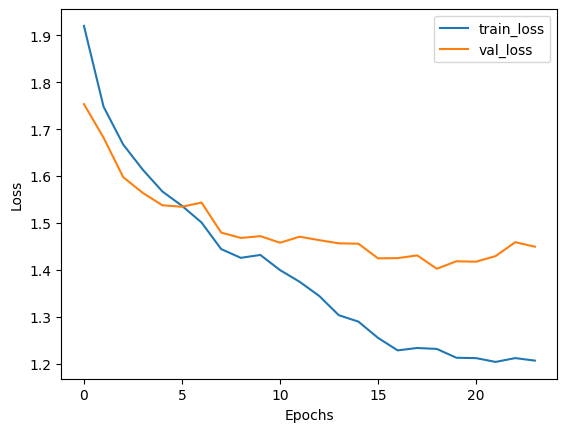

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
# now let's fine-tune by unfreezing some of the backbone

base_model.trainable = True   # unfreeze everything

# (Optional: unfreeze only the top N layers instead)
for layer in base_model.layers[:-35]: #30 was good! try more..
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=callbacks)
print("Fine-tuned eval:", model.evaluate(ds_test, verbose=0))

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 200ms/step - accuracy: 0.5063 - loss: 1.3406 - val_accuracy: 0.4731 - val_loss: 1.4452 - learning_rate: 1.0000e-05
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.5331 - loss: 1.2959 - val_accuracy: 0.4838 - val_loss: 1.4341 - learning_rate: 1.0000e-05
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5275 - loss: 1.3041 - val_accuracy: 0.4814 - val_loss: 1.4359 - learning_rate: 1.0000e-05
Epoch 4/50
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5433 - loss: 1.2458
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5432 - loss: 1.2461 - val_accuracy: 0.4802 - val_loss: 1.4628 - learning_rate: 1.0000e-05
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5626 - loss: 1.2401 - val_accuracy: 0.4874 - val_loss: 1.4479 - learning_rate: 2.0000e-06
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accur

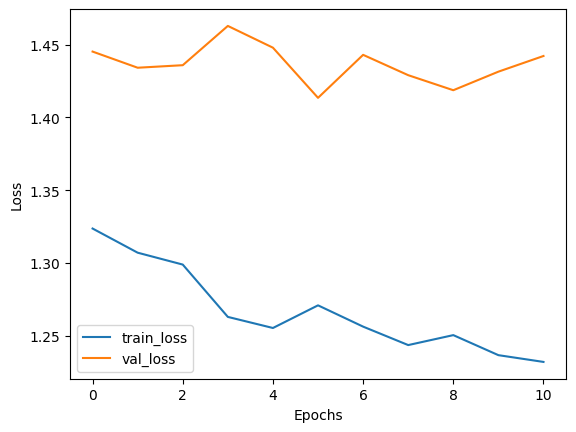

In [14]:
plt.plot(history_ft.history["loss"], label="train_loss")
plt.plot(history_ft.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Classification report
y_true = np.concatenate([y.numpy().argmax(axis=1) for _, y in ds_test])
y_prob = model.predict(ds_test, verbose=0)
y_pred = y_prob.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Test accuracy: 0.4784 | Test loss: 1.4459
              precision    recall  f1-score   support

       anger     0.1379    0.1504    0.1439       133
    contempt     0.1250    0.0286    0.0465        35
     disgust     0.0000    0.0000    0.0000        55
        fear     0.1159    0.0860    0.0988        93
   happiness     0.2545    0.3532    0.2958       201
  neutrality     0.0714    0.0659    0.0686        91
     sadness     0.1630    0.1389    0.1500       108
    surprise     0.1630    0.1897    0.1753       116

    accuracy                         0.1719       832
   macro avg     0.1288    0.1266    0.1224       832
weighted avg     0.1534    0.1719    0.1589       832

